In [1]:
import pandas as pd
import numpy as  np
from pyrocko import moment_tensor as mtm
from utils.stress import calc_Sh_azim, correct_pltr, calc_fault_angle, absolute_stress, understress
from scipy.io import loadmat
from pyproj import Transformer
from pyproj import CRS
from obspy.imaging import beachball
from obspy.geodetics.base import gps2dist_azimuth
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm, colors
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import seaborn as sns
import glob
import pyproj
import os

from joblib import Parallel, delayed

import warnings
warnings.filterwarnings("ignore")

In [2]:
csvjoined = "/home/ahmadfervo/cape/catalog/b060_catalog_ges_halliburton2.csv"
waveform_path = "/home/ahmadfervo/cape/waveforms"
station_path = "/home/ahmadfervo/cape/stationxml"
# eqnet_csv = "/home/ahmadfervo/cape/results_eqnet/picks.csv"
eqnet_csv = "/home/ahmadfervo/cape/picks_amp.csv"
nori_picks = "/home/ahmadfervo/cape/nori_picks"


# Define the NAD83 UTM zone 12 coordinate system
nad83_utm12 = pyproj.CRS("EPSG:26912")

# Define the WGS84 coordinate system
wgs84 = pyproj.CRS("EPSG:4326")

events = pd.read_csv(csvjoined)
events["origin_time"] = pd.to_datetime(events["origin_time"])
# events = events.rename(columns={"latitude_deg":"latitude","longitude_deg":"longitude"})

transformer = pyproj.Transformer.from_crs(nad83_utm12,wgs84,always_xy=True)

events['longitude'], events['latitude'] = transformer.transform(events['ges_Easting(m)'].values,events['ges_Northing(m)'].values)
events = events[(events["ges_time_diff_sec"]<1)]
# events = events[events["magnitude"]>0.5]
events = events.sort_values(by='magnitude',ascending=False)
events["depth_km"] = events["ges_Depth(m)"]*(-0.001) + 1.7
for idx,row in events.iterrows():
    events.loc[idx,["event_id"]] = f"eq{row['id']:05d}"

events[:3]

,Unnamed: 0,id,origin_time,latitude,longitude,magnitude,evaluation_mode,ges_Easting(m),ges_Northing(m),ges_Depth(m),...,hal_Depth m (TVDSS),hal_Quality,hal_date_time_local,hal_Well Name,hal_Stage Number,hal_event source type,hal_time_diff,hal_time_diff_sec,depth_km,event_id
6735,2882,2883,2024-02-26 03:50:07.230079,38.493718,-112.900911,2.987881,automatic,334223.3251,4262308.193,-974.3031,...,-973.86648,10.1581,2024-02-22 19:16:21.487,1l,26.0,Halliburton,3 days 01:33:45.743079,5625.0,2.674303,eq02883
6734,2386,2387,2024-02-23 03:14:38.422052,38.500605,-112.905224,2.641753,manual,333862.9931,4263080.333,-1413.2151,...,-973.86648,10.1581,2024-02-22 19:16:21.487,1l,26.0,Halliburton,0 days 00:58:16.935052,3496.0,3.113215,eq02387
6733,2736,2737,2024-02-25 11:11:20.386192,38.493722,-112.898967,2.402480,manual,334392.8931,4262305.165,-1151.0871,...,-973.86648,10.1581,2024-02-22 19:16:21.487,1l,26.0,Halliburton,2 days 08:54:58.899192,32098.0,2.851087,eq02737


In [ ]:
csvjoined = "/home/ahmadfervo/cape/catalog/GES_202406_mag01events.csv"
events = pd.read_csv(csvjoined)
events["origin_time"] = pd.to_datetime(events["origin_time"])

# events['longitude'], events['latitude'] = transformer.transform(events['ges_Easting(m)'].values,events['ges_Northing(m)'].values)
# events = events[(events["ges_time_diff_sec"]<1)]
# events = events[events["magnitude"]>0.5]
events = events.rename(columns={"magnitude":"ges_magnitude","event_index":"event_id",
                                "Easting(m)":"ges_Easting(m)","Northing(m)":"ges_Northing(m)","depth":"depth_km"})
events = events.sort_values(by='ges_magnitude',ascending=False)
print(len(events))
events[:3]

5386


,ges_Easting(m),ges_Northing(m),Depth(m),origin_time,ges_magnitude,Well Name,Stage Number,event source type,event_id,longitude,latitude,depth_km
0,333772.5091,4262261.069,-1309.5831,2024-06-09 14:49:22.789707,1.67,2P,22,GES,eq11365,-112.906067,38.493209,3.009583
1,333866.9971,4262248.877,-1477.2231,2024-06-08 06:07:13.799328,1.52,2P,17,GES,eq09799,-112.904981,38.493117,3.177223
2,333617.0611,4262178.773,-1928.3271,2024-06-09 10:04:35.011589,1.44,2P,21,GES,eq11049,-112.907829,38.492439,3.628327


In [4]:
skhash_result_path = "/home/ahmadfervo/cape/skhash/data06"
csv_files = glob.glob(f"{skhash_result_path}/*/OUT/out.csv")
print(len(csv_files))

def read_csv(csv_file):

    df = pd.read_csv(csv_file)

    return df


skresult = pd.concat(
    Parallel(n_jobs=16)(
        delayed(read_csv)(csv_file) for csv_file in csv_files
    )
    ,ignore_index=True)
skresult = skresult.sort_values(by=["quality"])
skresult = skresult.drop_duplicates(subset=["event_id"])
skresult[:3]

5207


,event_id,strike,dip,rake,quality,fault_plane_uncertainty,aux_plane_uncertainty,num_p_pol,num_sp_ratios,polarity_misfit,prob_mech,sta_distribution_ratio,sp_misfit,mult_solution_flag
897,eq11162,274.8859,19.9932,119.9282,A,17.6417,9.6831,56,56,11.5,100.0,70.3,-79.1,False
1110,eq08235,2.8926,55.5221,-158.1792,A,10.3218,10.1081,75,75,10.1,100.0,55.4,-89.2,False
1108,eq10084,344.3320,55.3469,-147.1526,A,9.4999,8.7826,63,63,10.4,100.0,59.8,-78.9,False


In [5]:
print(len(skresult[skresult["quality"].isin(["A","B"])]))

2423


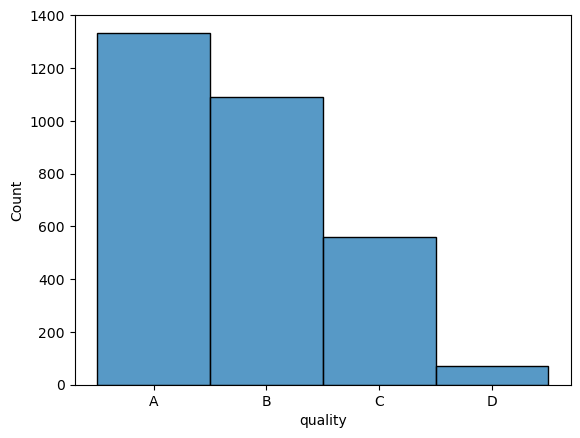

In [6]:
fig = plt.Figure(figsize=(6,8))
ax = fig.add_subplot()
sax = sns.histplot(data=skresult,x="quality")
ax.set_title("SKHASH quality")
fig.tight_layout()

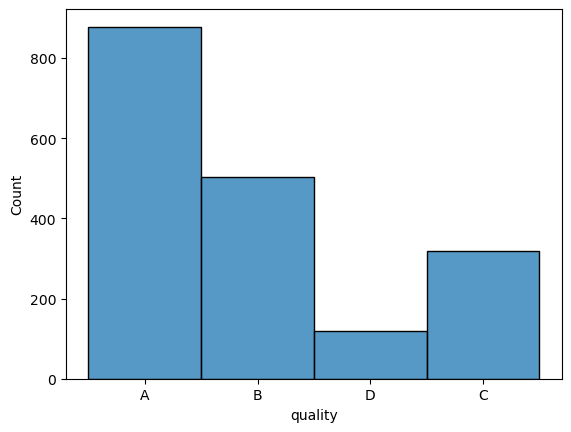

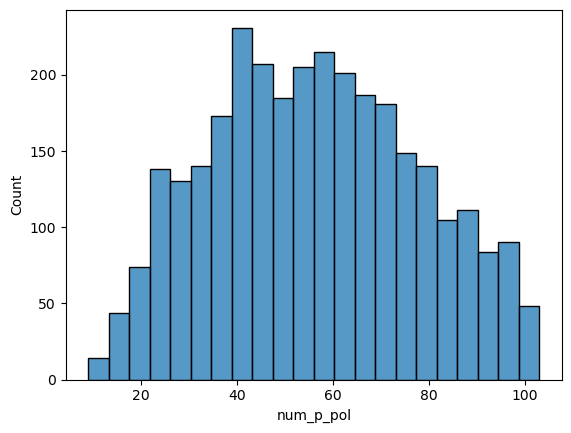

In [7]:
fig = plt.Figure(figsize=(6,8))
ax = fig.add_subplot()
sax = sns.histplot(data=skresult,x="num_p_pol")
ax.set_title("number of stations")
fig.tight_layout()

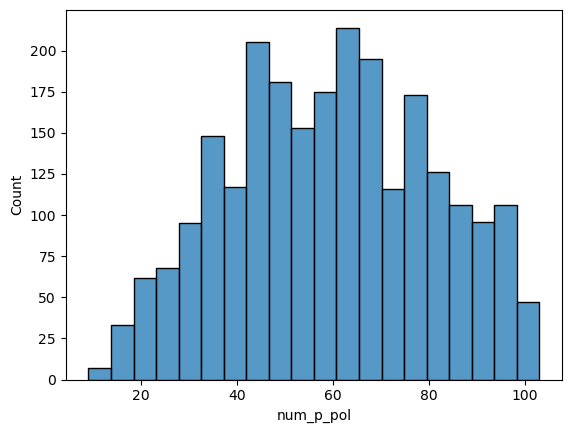

In [8]:
quality = ["A","B"]
fig = plt.Figure(figsize=(6,8))
ax = fig.add_subplot()
# sax = sns.histplot(data=skresult,x="num_p_pol")
sax = sns.histplot(data=skresult[skresult["quality"].isin(quality)],x="num_p_pol")
ax.set_title("number of stations")
fig.tight_layout()

In [9]:
fig_path = "/home/ahmadfervo/cape/skhash/figures06"

if not os.path.exists(fig_path):
    os.makedirs(fig_path)

In [10]:
def get_regime(rake):
    regime = "undefine"

    if -45 <= rake < 45:
        regime = "left-lateral-strike-slip"
    if 180-45 <= rake < 180+45:
        regime = "right-lateral-strike-slip"
    if -90-45 <= rake < -90+45:
        regime = "normal"
    if +90-45 <= rake < +90+45:
        regime = "reverse"

    return regime


def get_regime_scalar_faulting(sf):

    if -1.0 <= sf < -0.33:
        regime = "normal"
    elif -0.33 <= sf <= 0.33:
        regime = "strike-slip"
    elif 0.33 < sf <= 1.0:
        regime = "reverse"
    else:
        regime = "undefined"

    return regime

In [11]:
# quality = ["A","B","C","D"]
skresult = skresult.merge(events,on="event_id")
# skresult = skresult[skresult["quality"].isin(quality)]
skresult = skresult.sort_values(by=["ges_magnitude"],ascending=True)
print(len(skresult))

3052


In [11]:
fm_df = skresult

In [12]:
def add_regime(_idx,_row,dataframe):
    mag = _row["ges_magnitude"] 

    exp = mtm.magnitude_to_moment(mag)
    

    strike=_row[f'strike']
    dip=_row[f'dip']
    rake= _row[f'rake']
   
    mt = mtm.MomentTensor(
        strike=_row[f'strike'],
        dip=_row[f'dip'],
        rake= _row[f'rake']
    )

    pl1,pl2=mt.both_strike_dip_rake()
    s1,r1,d1 = pl1
    s2,r2,d2 = pl2
    
    fault_angle = calc_fault_angle(rake)

    p_ax = mt.p_axis()
    t_ax = mt.t_axis()
    b_ax = mt.null_axis()


    Ppl = np.degrees(np.arccos(p_ax[2]))
    Tpl = np.degrees(np.arccos(t_ax[2]))
    Bpl = np.degrees(np.arccos(b_ax[2]))
    Ptr = np.degrees(np.arctan2(p_ax[1], p_ax[0]))
    Ttr = np.degrees(np.arctan2(t_ax[1], t_ax[0]))
    Btr = np.degrees(np.arctan2(b_ax[1], b_ax[0]))
    
    Ppl,Ptr = correct_pltr(Ppl, Ptr,p_ax)
    Tpl,Ttr = correct_pltr(Tpl, Ttr,p_ax)
    Bpl,Btr = correct_pltr(Bpl, Btr,p_ax)

    fm_df.loc[_idx,[f'Ppl']] = Ppl
    fm_df.loc[_idx,[f'Ptr']] = Ptr

    fm_df.loc[_idx,[f'Tpl']] = Tpl
    fm_df.loc[_idx,[f'Ttr']] = Ttr

    fm_df.loc[_idx,[f'Bpl']] = Bpl
    fm_df.loc[_idx,[f'Btr']] = Btr
    

    Sh_az,regime = calc_Sh_azim(Ppl,Ptr,Tpl,Ttr,Bpl,Btr)
    nregime = get_regime(rake)

    fm_df.loc[_idx,[f'Sh_azimuth']] = Sh_az
    fm_df.loc[_idx,[f'regime']] = regime
    fm_df.loc[_idx,[f'regime_nori']] = nregime
    fm_df.loc[_idx,[f'fault_angle']] = fault_angle

In [13]:
fm_df.loc[:,f'Ppl'] = None
fm_df.loc[:,f'Ptr'] = None

fm_df.loc[:,f'Tpl'] = None
fm_df.loc[:,f'Ttr'] = None

fm_df.loc[:,f'Bpl'] = None
fm_df.loc[:,f'Btr'] = None

fm_df.loc[:,f'Sh_azimuth'] = None
fm_df.loc[:,f'regime'] = None
fm_df.loc[:,f'regime_nori'] = None
fm_df.loc[:,f'regime_scalar_faulting'] = None
fm_df.loc[:,f'fault_angle'] = None
fm_df.loc[:,f'strike2'] = None
fm_df.loc[:,f'dip2'] = None
fm_df.loc[:,f'rake2'] = None


# Parallel(n_jobs=16)(
#     delayed(add_regime)(idx,row) for idx, row in fm_df.iterrows()
# )

for idx,row in fm_df.iterrows():

    mag = row["ges_magnitude"] 

    exp = mtm.magnitude_to_moment(mag)
    

    strike=row[f'strike']
    dip=row[f'dip']
    rake= row[f'rake']
   
    mt = mtm.MomentTensor(
        strike=row[f'strike'],
        dip=row[f'dip'],
        rake= row[f'rake']
    )

    pl1,pl2=mt.both_strike_dip_rake()
    s1,r1,d1 = pl1
    s2,r2,d2 = pl2
    
    fault_angle = calc_fault_angle(rake)

    p_ax = mt.p_axis()
    t_ax = mt.t_axis()
    b_ax = mt.null_axis()


    Ppl = np.degrees(np.arccos(p_ax[2]))
    Tpl = np.degrees(np.arccos(t_ax[2]))
    Bpl = np.degrees(np.arccos(b_ax[2]))
    Ptr = np.degrees(np.arctan2(p_ax[1], p_ax[0]))
    Ttr = np.degrees(np.arctan2(t_ax[1], t_ax[0]))
    Btr = np.degrees(np.arctan2(b_ax[1], b_ax[0]))
    
    Ppl,Ptr = correct_pltr(Ppl, Ptr,p_ax)
    Tpl,Ttr = correct_pltr(Tpl, Ttr,p_ax)
    Bpl,Btr = correct_pltr(Bpl, Btr,p_ax)

    fm_df.loc[idx,[f'Ppl']] = Ppl
    fm_df.loc[idx,[f'Ptr']] = Ptr

    fm_df.loc[idx,[f'Tpl']] = Tpl
    fm_df.loc[idx,[f'Ttr']] = Ttr

    fm_df.loc[idx,[f'Bpl']] = Bpl
    fm_df.loc[idx,[f'Btr']] = Btr
    

    Sh_az,regime = calc_Sh_azim(Ppl,Ptr,Tpl,Ttr,Bpl,Btr)
    nregime = get_regime(rake)

    fm_df.loc[idx,[f'Sh_azimuth']] = Sh_az
    fm_df.loc[idx,[f'regime']] = regime
    fm_df.loc[idx,[f'regime_nori']] = nregime
    sfregime = get_regime_scalar_faulting(fault_angle)
    fm_df.loc[idx,[f'regime_scalar_faulting']] = sfregime
    fm_df.loc[idx,[f'fault_angle']] = fault_angle

    fm_df.loc[idx,f'strike2'] = s1
    fm_df.loc[idx,f'dip2'] = d1
    fm_df.loc[idx,f'rake2'] = r1
    

In [14]:
fm_df.to_csv("/home/ahmadfervo/cape/skhash/focal_mechanisms_regime06.csv",index=False, float_format="%.4f")
fm_df[:4]

,event_id,strike,dip,rake,quality,fault_plane_uncertainty,aux_plane_uncertainty,num_p_pol,num_sp_ratios,polarity_misfit,...,Bpl,Btr,Sh_azimuth,regime,regime_nori,regime_scalar_faulting,fault_angle,strike2,dip2,rake2
1032,eq09848,232.1511,44.8563,-81.3424,A,19.4693,22.0796,30,30,12.4,...,6.094751,45.990629,406.040741,NF,normal,normal,-0.903804,232.1511,-81.3424,44.8563
1034,eq10047,346.0510,41.2131,148.5552,A,19.2851,11.6169,40,40,12.7,...,34.20137,115.15686,216.991246,TS,right-lateral-strike-slip,reverse,0.349387,100.753044,53.232363,69.89676
2480,eq10561,165.1623,77.2499,161.9092,C,6.4470,5.5502,46,46,23.7,...,67.991229,311.11945,212.840895,SS,right-lateral-strike-slip,strike-slip,0.201009,259.285983,13.38985,72.370123
2434,eq08212,352.9300,65.7937,176.9911,C,8.7879,13.2105,55,55,24.6,...,65.61859,90.235271,221.203998,SS,right-lateral-strike-slip,strike-slip,0.033432,84.164663,24.235873,87.25587


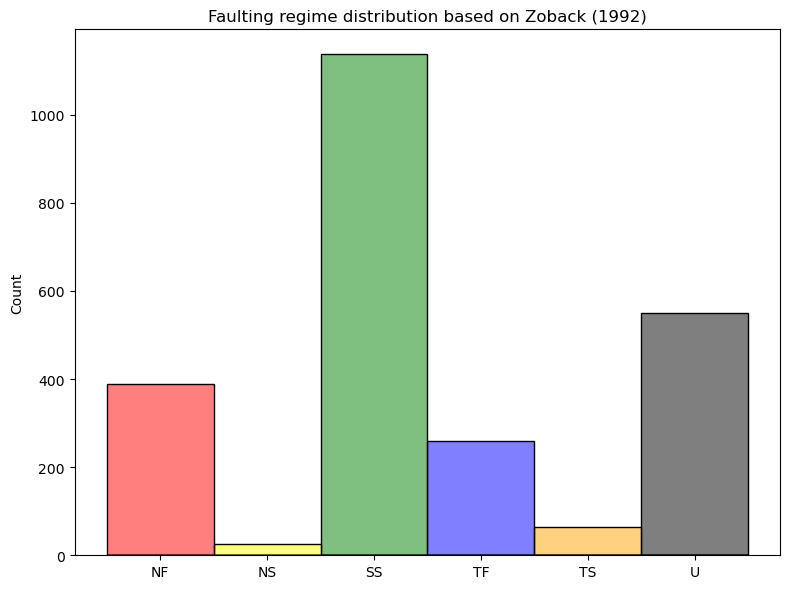

In [15]:
colors = {"SS":"green","TF":"blue","NF":"red","NS":"yellow","TS":"orange","U":"black"}
quality = ["A","B"]
fm_df = fm_df[fm_df["quality"].isin(quality)]
fm_df = fm_df.sort_values(by=["regime"])
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
sns.histplot(data=fm_df,x='regime',hue='regime',palette=colors, legend=False)
ax.set_xlabel('')
ax.set_title("Faulting regime distribution based on Zoback (1992)")
fig.tight_layout()
fig.savefig(f'{fig_path}/faultregime_hist_zoback.png',dpi=300)

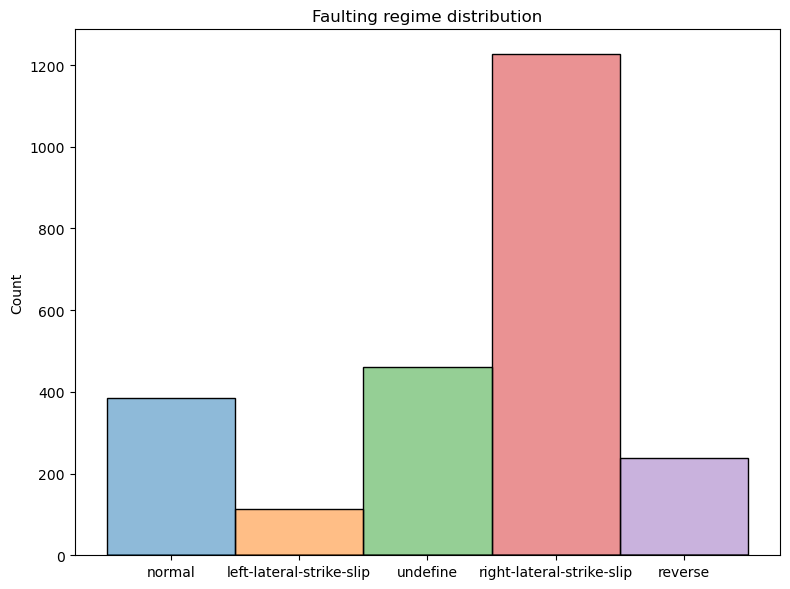

In [16]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
sns.histplot(data=fm_df,x='regime_nori',hue='regime_nori',legend=False)
ax.set_xlabel('')
ax.set_title("Faulting regime distribution")
fig.tight_layout()
fig.savefig(f'{fig_path}/faultregime_hist_nori.png',dpi=300)

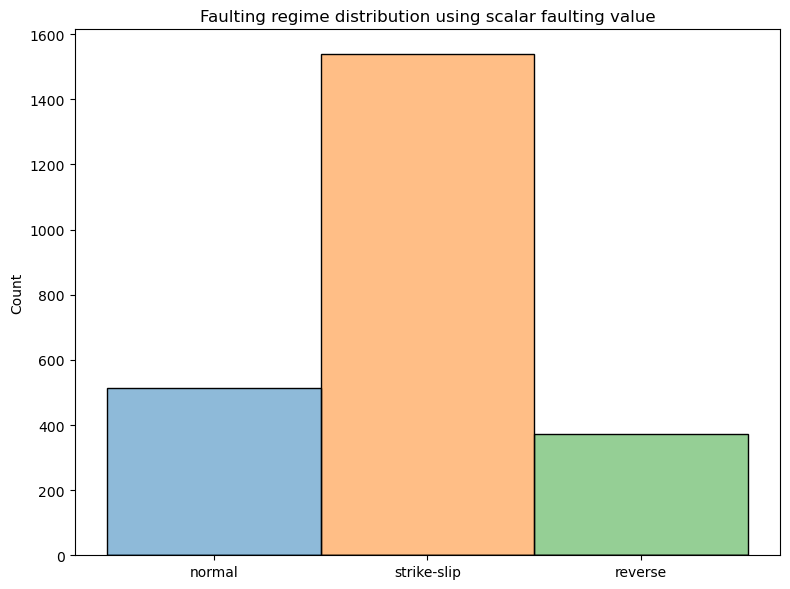

In [17]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
sns.histplot(data=fm_df,x='regime_scalar_faulting',hue='regime_scalar_faulting',legend=False)
ax.set_xlabel('')
ax.set_title("Faulting regime distribution using scalar faulting value")
fig.tight_layout()
fig.savefig(f'{fig_path}/faultregime_hist_scalar_faulting.png',dpi=300)

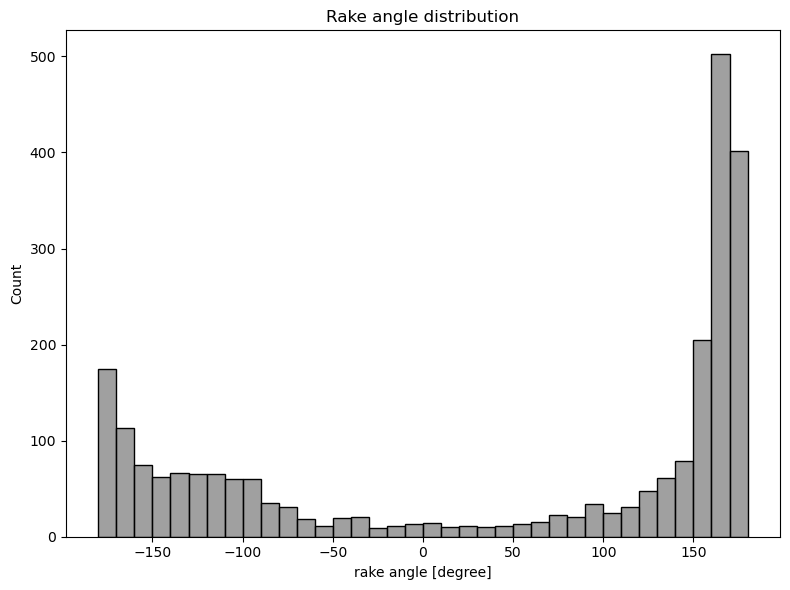

In [18]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
sns.histplot(data=fm_df,x='rake',color="grey",binwidth=10)
ax.set_xlabel('rake angle [degree]')
ax.set_title("Rake angle distribution")
fig.tight_layout()
fig.savefig(f'{fig_path}/rakeangle_hist.png',dpi=300)

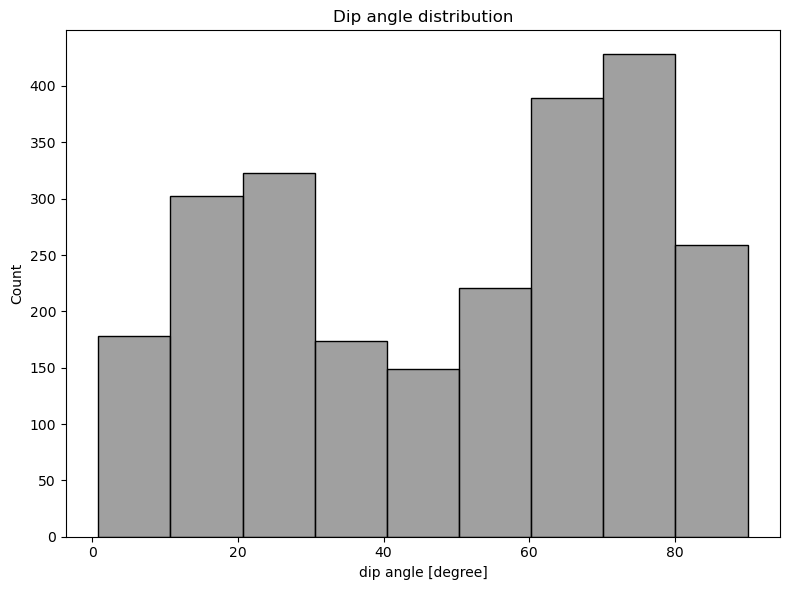

In [19]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
sns.histplot(data=fm_df,x='dip',color="grey",binwidth=10)
ax.set_xlabel('dip angle [degree]')
ax.set_title("Dip angle distribution")
fig.tight_layout()
fig.savefig(f'{fig_path}/dipangle_hist.png',dpi=300)

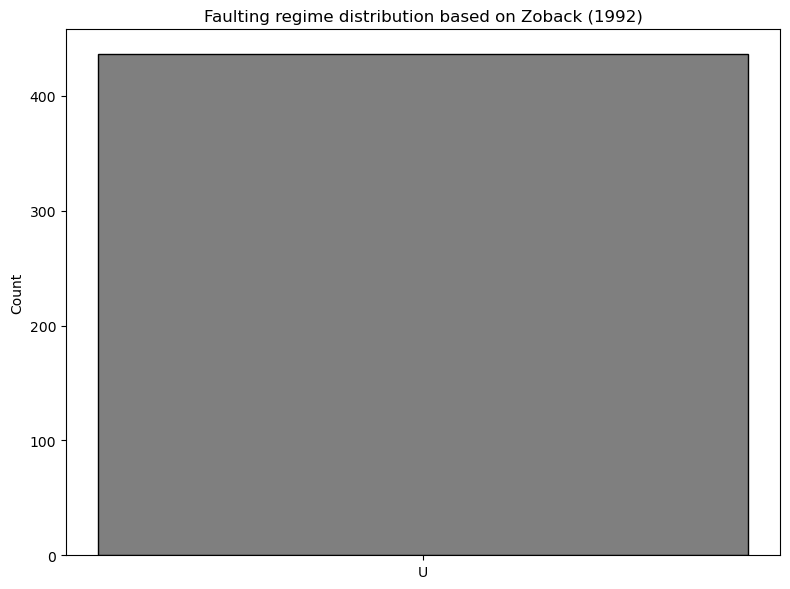

In [19]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
sns.histplot(data=fm_df[fm_df["Sh_azimuth"] == 0],x='regime',hue='regime',palette=colors, legend=False)
ax.set_xlabel('')
ax.set_title("Faulting regime distribution based on Zoback (1992)")
fig.tight_layout()

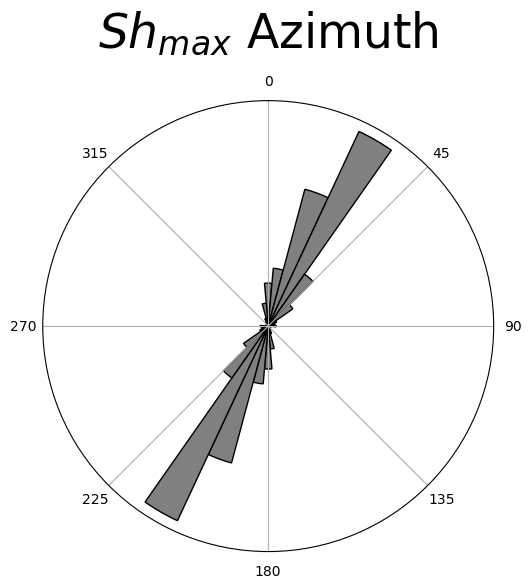

In [20]:
strikes = fm_df[fm_df["Sh_azimuth"] != 0]["Sh_azimuth"].values
bin_edges = np.arange(0, 361, 10)
number_of_strikes, bin_edges = np.histogram(strikes, bin_edges)
number_of_strikes[0] += number_of_strikes[-1]
half = np.sum(np.split(number_of_strikes[:], 2), 0)
two_halves = np.concatenate([half, half])

fig = plt.figure(figsize=(9,6))

ax = fig.add_subplot(111, projection='polar')

ax.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves,
       width=np.deg2rad(10), bottom=0.0, color='gray',edgecolor='k')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 45), labels=np.arange(0, 360, 45))
ax.set_rgrids([], angle=0)
ax.set_title(r'$Sh_{max}$ Azimuth', y=1.10, fontsize=34)

fig.tight_layout()
fig.savefig(f'{fig_path}/shmax_hist.png',dpi=300)

In [21]:
strike1 = fm_df["strike"].values
strike2 = fm_df["strike2"].values

strikes = np.concatenate([strike1,strike2])
strikes

array([232.1511, 224.485, 208.7897, ..., 151.64244770955565,
       111.88300819816398, 241.5285277441186], dtype=object)

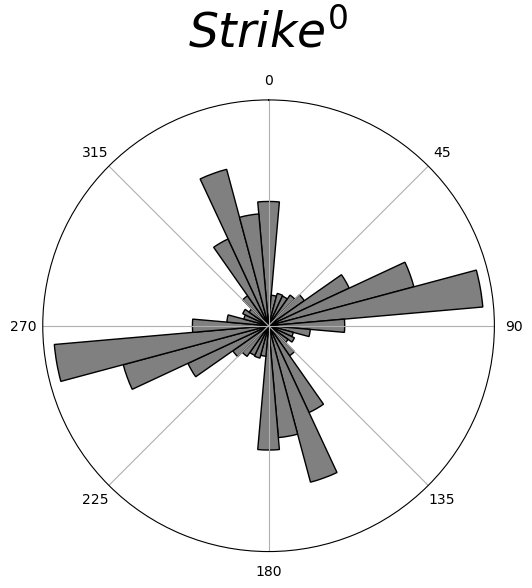

In [22]:

strike1 = fm_df["strike"].values
strike2 = fm_df["strike2"].values

strikes = np.concatenate([strike1,strike2])

bin_edges = np.arange(0, 361, 10)
number_of_strikes, bin_edges = np.histogram(strikes, bin_edges)
number_of_strikes[0] += number_of_strikes[-1]
half = np.sum(np.split(number_of_strikes[:], 2), 0)
two_halves = np.concatenate([half, half])

fig = plt.figure(figsize=(9,6))

ax = fig.add_subplot(111, projection='polar')

ax.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves,
       width=np.deg2rad(10), bottom=0.0, color='gray',edgecolor='k')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 45), labels=np.arange(0, 360, 45))
ax.set_rgrids([], angle=0)
ax.set_title(r'$Strike^{0}$', y=1.10, fontsize=34)

fig.tight_layout()
fig.savefig(f'{fig_path}/strike_hist.png',dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


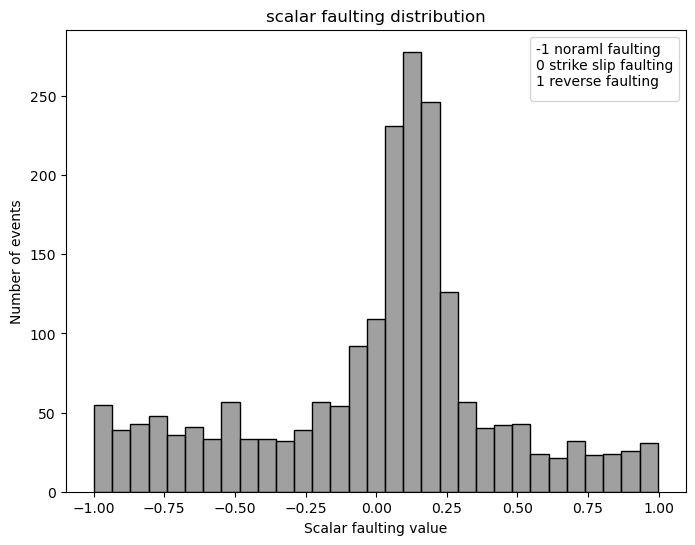

In [23]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
sns.histplot(data=fm_df,x='fault_angle', ax=ax, color="grey")# legend=False,color='darkred')
# sns.displot(data=fms,x='fault_angle',kind='kde')
ax.set_xlabel('Scalar faulting value')
ax.set_ylabel('Number of events')
# ax.plot([],[],'', label="-1 noraml faulting")
# ax.plot([],[],'',label=" 0 strike slip faulting")
# ax.plot([],[],'',label=" 1 reverse faulting")
ax.set_title('scalar faulting distribution')
ax.legend(title='-1 noraml faulting\n0 strike slip faulting\n1 reverse faulting')
fig.savefig(f'{fig_path}/faultangle_hist.png',dpi=300)

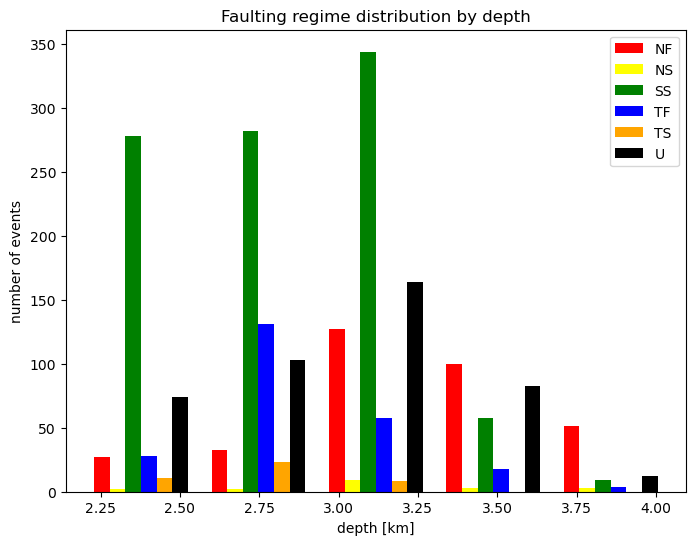

In [28]:
colors = {"SS":"green","TF":"blue","NF":"red","NS":"yellow","TS":"orange","U":"black"}
_regimes = fm_df['regime'].unique().tolist()
_colors = [colors[k] for k in _regimes]
x=[]
for reg in _regimes:
    df = fm_df[fm_df['regime']==reg]
    d = df['depth_km'].values
    x.append(d)

# x = np.array(x,type=object)
# x.shape
nbins=5
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.hist(x,nbins, histtype='bar',label=_regimes,color=_colors)
ax.legend()
ax.set_xlabel('depth [km]')
ax.set_ylabel('number of events')
ax.set_title('Faulting regime distribution by depth')
plt.tick_params(axis='both', which='major')
fig.savefig(f'{fig_path}/faultregime_depth_hist_zoback1992.png',dpi=300)

In [ ]:
d

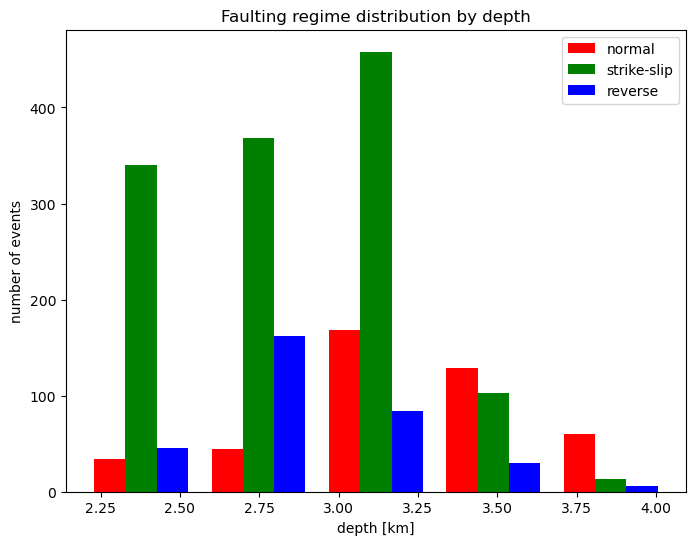

In [29]:
colors = {"strike-slip":"green","reverse":"blue","normal":"red"}
_regimes = fm_df['regime_scalar_faulting'].unique().tolist()
_colors = [colors[k] for k in _regimes]
x=[]
for reg in _regimes:
    df = fm_df[fm_df['regime_scalar_faulting']==reg]
    d = df['depth_km'].values
    x.append(d)

# x = np.array(x)
# x.shape
nbins=5
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.hist(x,nbins, histtype='bar',label=_regimes,color=_colors)
ax.legend()
ax.set_xlabel('depth [km]')
ax.set_ylabel('number of events')
ax.set_title('Faulting regime distribution by depth')
plt.tick_params(axis='both', which='major')
fig.savefig(f'{fig_path}/faultregime_depth_hist_scalar_faulting.png',dpi=300)